In [4]:
# Imports

import glob
import os.path as path
from scipy import misc
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# define method for making spectogram
# modified from Ernst's spectrogram.py in Pylos github

import wave, struct
from math import *
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from scipy import signal
import sys
import pylab
import os

import datetime
import string

from bandpass_filter import *

def usage():
    print("Usage:  %s  <wav-file> <t_min (s)> <t_max (s)> \n"
          % os.path.basename(sys.argv[0]))


def get_timestamp(filename, begin_time):
    s = os.path.splitext(os.path.basename(filename))[0][10:]
    extra_minute = int(begin_time/60.)
    extra_second = int(begin_time - extra_minute*60.)
    hours = int(s[6:8])
    minutes = int(s[8:10]) + extra_minute
    seconds = int(s[10:12]) + extra_second
    if seconds > 60:
        minutes += 1
        seconds -= 60
    if minutes > 60:
        hours +=1
        minutes -= 60
        
    date = datetime.datetime(year=2000+ int(s[0:2]), month=int(s[2:4]), \
                             day=int(s[4:6]), \
                             hour = hours, minute = minutes, second = seconds)
    return date

# will have to change in order to save png of just image 
def graph_spectrogram(wav_file, begin, end, cutoff_low, cutoff_high, order, image_name):
    sound_info, Fs = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    #pylab.title('spectrogram of %r' % wav_file)
    nfft = 1024 # play around with this to change width of blocks (originally it is 1024)
    data = sound_info[int(begin*Fs): int(end*Fs)]
    data = butter_bandpass_filter(data, cutoff_low, cutoff_high, Fs, order)
    plt.ylim([0, 20000])
    pylab.specgram(data, Fs=Fs, NFFT = nfft, \
                   noverlap =int(nfft * (4./5)), # play around with overlap (originally it is int(nff2/2))
                   cmap='coolwarm', \
                   mode = 'psd')
    _, _, spectrum = signal.spectrogram(data)
    plt.axis('off')
    plt.savefig(image_name, transparent = True, bbox_inches='tight', pad_inches=0) 

    #pylab.colorbar()      
    #    datestring = get_timestamp(wav_file, begin)
    #    pylab.xlabel("Time (seconds since {}) [s]".format(datestring), \
        #                 size = 16, ha ='right', x=1.0)
    #pylab.xlabel("Time (seconds)", size = 16, ha ='right', x=1.0)
    #pylab.ylabel("PSD", size = 16, ha ='right', position=(0,1))
    #pylab.show()
    plt.close()
    return spectrum
    
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

def make_spectrogram(filename, begin, end, image_name):
    cutoff_low = 100.
    cutoff_high = 5000.
    order = 5 
    spectrum = graph_spectrogram(filename, begin, end, cutoff_low, cutoff_high, order, image_name)
    return spectrum 

In [37]:
def make_all_spectrograms(wav_path, fn, spectrogram_folder_path):
    
    # Read in WAV File, compute stats
    full_fn = wav_path + fn + ".wav"
    r = read(full_fn)
    wavArr = np.array(r[1],dtype=float)
    rate = r[0]
    #plt.plot(wavArr) # test
    #plt.show() # test
    std = np.std(wavArr)
    avg = np.mean(wavArr)
    print("Average: ", avg, 
          "\nStandard Deviation: ", std, 
          "\nRate: ", rate) # test
    print(wavArr.shape)
    
    # record start of clicks

    # compute the noise by averaging measurments within one std dev of mean
    counter = 0
    noise = 0
    for i in wavArr:
        # test under here
        if (counter % 10000000 == 0):
            print(counter)
        # if value within one standard dev., use as part of noise calculation
        if (i < (avg + std) and i > (avg - std)):
            noise = noise + i
            counter = counter + 1
    noise = noise / counter
    print("Noise: ", noise)

    # threshold is 4.5 Sound-to-Noise ratio
    threshold = 4.5 * noise
    print("Threshold ", threshold)

    counter = 0
    clickStarts = []
    clickStartsSeconds = []
    first = True
    nearby = False
    nearbyCount = 0

    # looks at each instance in array representing .wav file
    for i in wavArr:

        # sees if value of instance above or below certain threshold
        if (i > threshold):
            # if no other click is nearby add to counter
            if (not nearby):
                clickStarts.append(counter)
                clickStartsSeconds.append(float(counter) / rate)
            # set nearby to true and reset nearby count
            nearby = True;
            nearbyCount = 0

        # if it has been .02 seconds since a click, reset nearby to false and nearbyCounter to 0 
        if (nearbyCount > (rate * .02)):
            nearby = False 
            nearbyCount = 0

        # if nearby a click then increment the clickCounter
        if (nearby):
            nearbyCount += 1

        # increment general counter
        counter += 1

    print(clickStartsSeconds) # test
    
    # instantiate arrays for 1d and 2d CNNS
    fullX1d = np.array([])
    fullY1d = np.array([[0]])
    fullX2d = np.array([])
    fullY2d = np.array([[0]])
    
    # set spectrogram dimensions
    spectrum_timesteps = 192
    spectrum_frequencies = 129
    
    # construct spectrogram from when click occurs to .3 seconds after and append to time-series arrays
    imagePaths = []
    for j in range(len(clickStartsSeconds)):
        
        beginning = clickStartsSeconds[j]
        end = clickStartsSeconds[j] + .3
        
        # constructing spectrogram
        save_fn = spectrogram_folder_path + fn + "Spectrogram" + str(j)
        print("Beginning: ", beginning, " End: ", end)
        spectrum = make_spectrogram(full_fn, beginning, end, save_fn)
        spectrum = spectrum.transpose()
        imagePaths.append(save_fn)
        
        # appending to arrays
        timesteps1d = np.array([])
        for k in range(j, j + int(.3 * rate)):
            timesteps1d = np.append(timesteps1d, np.array([wavArr[k]]), axis = 0)
        #np.savetxt(array_folder_path_1d, timesteps1d)
        #np.savetxt(array_folder_path_2d, spectrum)
        fullX1d = np.append(fullX1d, timesteps1d, axis = 0)
        fullX2d = np.append(fullX2d, spectrum)
        fullY1d = np.append(fullY1d, [[0]], axis = 0)
        fullY2d = np.append(fullY2d, [[0]], axis = 0)
        print("#", j, " out of ", len(clickStartsSeconds)) #TEST
    
    # reformat arrays
    fullX1d.resize(len(clickStartsSeconds), int(.3 * rate), 1)
    fullX2d.resize(len(clickStartsSeconds), spectrum_timesteps, spectrum_frequencies)

    # return all arrays
    return imagePaths, fullX1d, fullY1d[1:], fullX2d, fullY2d[1:]

In [25]:
# testing function on very small dataset

_, fullX1d, fullyY1d, fullX2d, fullyY2d = make_all_spectrograms("C:/Users/nssaf/Neutrino Project/data/clicks/", "Part 1", "C:/Users/nssaf/Neutrino Project/data/spectrograms/Wav 1/", "C:/Users/nssaf/Neutrino Project/data/spectrograms/1d arrays", "C:/Users/nssaf/Neutrino Project/data/spectrograms/2d arrays")

Average:  342.4671254092548 
Standard Deviation:  255.55325267111877 
Rate:  144000
(137769928,)
0
10000000
20000000
30000000
40000000
50000000
60000000
70000000
80000000
90000000
100000000
110000000
120000000
Noise:  348.3421144115046
Threshold  1567.5395148517707
[22.526506944444446, 22.590118055555557, 24.601555555555557, 24.851041666666667, 25.084972222222223, 27.98770138888889, 30.81096527777778, 43.73223611111111, 67.28045138888889, 70.69479861111111, 70.76046527777778, 73.3933888888889, 73.6444861111111, 77.68936111111111, 77.80523611111111, 77.93465277777777, 78.17156944444444, 82.02279861111111, 90.5155625, 90.63707638888889, 90.8168125, 91.01786111111112, 100.13122222222222, 105.59227083333333, 117.23927083333334, 117.35627083333334, 117.4375625, 117.50323611111111, 117.73821527777778, 131.8215277777778, 141.094375, 141.21318055555557, 141.28965277777777, 141.35815277777778, 141.57810416666666, 145.453, 157.12215277777779, 157.61626388888888, 161.30839583333332, 161.579055555

C:\Users\nssaf\Miniconda3\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


# 0  out of  158
Beginning:  22.590118055555557  End:  22.890118055555558
# 1  out of  158
Beginning:  24.601555555555557  End:  24.901555555555557
# 2  out of  158
Beginning:  24.851041666666667  End:  25.151041666666668
# 3  out of  158
Beginning:  25.084972222222223  End:  25.384972222222224
# 4  out of  158
Beginning:  27.98770138888889  End:  28.28770138888889
# 5  out of  158
Beginning:  30.81096527777778  End:  31.11096527777778
# 6  out of  158
Beginning:  43.73223611111111  End:  44.03223611111111
# 7  out of  158
Beginning:  67.28045138888889  End:  67.58045138888889
# 8  out of  158
Beginning:  70.69479861111111  End:  70.99479861111111
# 9  out of  158
Beginning:  70.76046527777778  End:  71.06046527777778
# 10  out of  158
Beginning:  73.3933888888889  End:  73.69338888888889
# 11  out of  158
Beginning:  73.6444861111111  End:  73.9444861111111
# 12  out of  158
Beginning:  77.68936111111111  End:  77.98936111111111
# 13  out of  158
Beginning:  77.80523611111111  End:  7

# 113  out of  158
Beginning:  811.7729375  End:  812.0729375
# 114  out of  158
Beginning:  815.9674444444445  End:  816.2674444444444
# 115  out of  158
Beginning:  824.6768263888889  End:  824.9768263888889
# 116  out of  158
Beginning:  843.4361319444445  End:  843.7361319444444
# 117  out of  158
Beginning:  843.6928611111111  End:  843.9928611111111
# 118  out of  158
Beginning:  843.9187569444445  End:  844.2187569444444
# 119  out of  158
Beginning:  848.1720972222222  End:  848.4720972222221
# 120  out of  158
Beginning:  848.4468680555556  End:  848.7468680555555
# 121  out of  158
Beginning:  848.6585  End:  848.9585
# 122  out of  158
Beginning:  851.9993333333333  End:  852.2993333333333
# 123  out of  158
Beginning:  852.2673958333334  End:  852.5673958333333
# 124  out of  158
Beginning:  867.4556388888889  End:  867.7556388888888
# 125  out of  158
Beginning:  867.6474097222223  End:  867.9474097222222
# 126  out of  158
Beginning:  867.7055833333334  End:  868.00558333

In [26]:
# making sure data is right

print(fullX1d.shape, fullyY1d.shape, fullX2d.shape, fullyY2d.shape)


(158, 43200, 1) (158, 1) (158, 192, 129) (158, 1)


In [3]:
import numpy as np

# playing around with numpy arrays

d = np.array([[0]])
print(d)
print(d.shape)
d = np.append(d, [[0]], axis = 0)
print(d)
print(d.shape)

e = np.array([[0]])
for i in range(int(144000 * .3) - 1):
    e = np.append(e, [[0]], axis = 0)
f = np.array([e])
print(f)
print(f.shape)

a = np.array([1, 2, 3, 4, 5, 6])
a.resize((2, 3, 1))
print(a)

b = np.array([[1, 4, 7], 
              [2, 5, 8], 
              [3, 6, 9]])
print(b.transpose())

x = 
c = np.vstack(([[1,2],
                [3, 4]]
               ,
               [[[5, 6],
                [7, 8]]]))
print(c.shape)
print(c)



[[0]]
(1, 1)
[[0]
 [0]]
(2, 1)
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]
(1, 43200, 1)
[[[1]
  [2]
  [3]]

 [[4]
  [5]
  [6]]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
(2, 2, 2)
[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]


In [41]:
# RUN WITH CAUTION!!! TAKES A LONG TIME
# generate wav for all files

# clear former arrays
fullX1d = np.array([])
fullY1d = np.array([])
fullX2d = np.array([])
fullY2d = np.array([])

# the number of wav files analyzed (up to x = 9)
x = 5

# for each wav file (represented by folder)
for i in range(1, x + 1):
    wav = "Wav " + str(i)
    print("\n\n\n\n", wav, "\n\n\n\n")
    # for each part of wav file (which is itself a wav file)
    for j in range(1, 9):
        part = "Part " + str(j)
        print("\n\n\n\n", part, "\n\n\n\n")
        _, partX1d, partY1d, partX2d, partY2d = make_all_spectrograms("C:/Users/nssaf/Neutrino Project/data/clicks/" + wav + "/", part, "C:/Users/nssaf/Neutrino Project/data/spectrograms/" + wav + "/")
        # print dimensions (TEST)
        print(partX1d.shape, partY1d.shape, partX2d.shape, partY2d.shape) #TEST
        print(fullX1d.shape, fullyY1d.shape, fullX2d.shape, fullyY2d.shape) #TEST
        fullX1d = np.vstack((fullX1d, partX1d))
        fullY1d = np.vstack((fullY1d, partY1d))
        fullX2d = np.vstack((fullX2d, partX2d))
        fullY2d = np.vstack((fullY2d, partY2d))
        





 Wav 1 








 Part 1 




Average:  342.4075482807976 
Standard Deviation:  55.66301773499214 
Rate:  144000
(131910673,)
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
10000000
20000000
30000000
40000000
50000000
60000000
70000000
80000000
90000000
Noise:  342.79163574344307
Threshold  1542.562360845494
[]
(0, 43200, 1) (0, 1) (0, 192, 129) (0, 1)
(0,) (158, 1) (0,) (158, 1)


ValueError: all the input arrays must have same number of dimensions

In [ ]:
# Reapportion training and testing sets
# SHOULD SHUFFLE

training_samples = int(fullX1d[0] * .75)

# seperate training and testing arrays for 1d CNN
trainX1d = fullX1d[0:training_samples]
testX1d = fullX1d[training_samples:]
trainY1d = fullY1d[0:training_samples]
testY1d = fullY1d[training_samples:]

# seperate training and testing arrays for 2d CNN
trainX2d = fullX2d[0:training_samples]
testX2d = fullX2d[training_samples:]
trainY2d = fullY2d[0:training_samples]
testY2d = fullY2d[training_samples:]

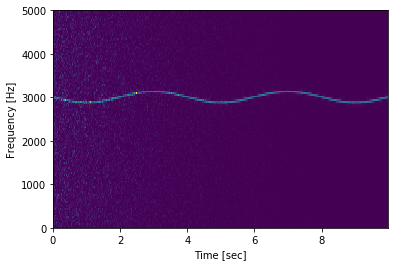

(129, 446)


In [102]:
# playing around with scipy spectrogram package

from scipy import signal
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [104]:
# playing around with scipy spectrogram package (cont.)

print(f.shape)
print(t.shape)
print(Sxx.shape)

print(Sxx)

(129,)
(446,)
(129, 446)
[[8.18406226e-04 3.06468734e-04 7.43983399e-04 ... 2.10133755e-06
  3.63153166e-07 1.69555314e-07]
 [2.60711754e-02 3.76360624e-02 7.96338127e-03 ... 1.00136975e-04
  8.14686438e-05 5.43852622e-05]
 [2.35246179e-02 5.73772903e-03 2.18506848e-02 ... 3.36936015e-04
  1.39927689e-04 3.00703854e-04]
 ...
 [1.47578754e-03 6.01528048e-03 1.20872108e-02 ... 1.39033862e-05
  1.24276595e-04 3.58060745e-05]
 [2.96986181e-02 2.20734109e-03 5.46432880e-03 ... 3.41774031e-04
  2.61048186e-04 1.04520213e-04]
 [1.09876665e-02 6.73991083e-04 2.03314041e-06 ... 2.04674219e-06
  1.26331213e-04 1.02446330e-04]]
